# Introduction
How to open and understand the dataset

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Basic information
1. Hyperspectral data:
    1. `hsi_path` contains path to hyperspectral masked numpy arrays containing hyperspectral data that underwent masking (i.e., the field area is masked, whereas all irrelevant areas are not masked)
    2. The name of the file (e.g., _'1989.npz'_) refers to the index of the corresponding training sample in the ground-truth table.
2. Ground-truth data:
    1. `gt_path` contains path to ground truth .csv file.
    2. Additionally, `wavelength_path` contains the mapping between a band number and the corresponding wavelength.


In [30]:
hsi_path = '../train_data/train_data/train_data/1500.npz'
gt_path = '../train_data/train_data/train_gt.csv'
wavelength_path = '../train_data/train_data/wavelengths.csv'

In [31]:
gt_df = pd.read_csv(gt_path)
wavelength_df = pd.read_csv(wavelength_path)

## Ground-truth description
`gt_df` contains:

1. `sample_index` - a reference to the numpay array containing the corresponding hyperspectral data.
2. P (for simplicity, we use P while referring to P_2O_5), K, Mg, pH - soil properties levels based on laboratory measurements.

In [32]:
gt_df[gt_df['sample_index']==150]

,sample_index,P,K,Mg,pH
150,150,140.0,312.0,216.0,7.4


## Displaying one hyperspectral band

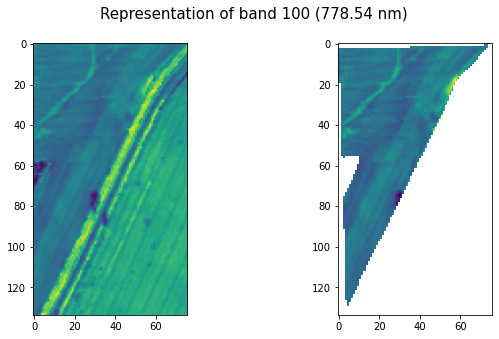

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
band_id = 100
wavelength = wavelength_df.loc[band_id-1]

with np.load(hsi_path) as npz:
    arr = np.ma.MaskedArray(**npz)

axs[0].imshow(arr[band_id,:,:].data)
axs[1].imshow(arr[band_id,:,:])

plt.suptitle(f'Representation of band {int(wavelength["band_no"])} ({wavelength["wavelength"]} nm)', fontsize=15)
plt.show()

## Displaying the aggregated spectral curve for a field

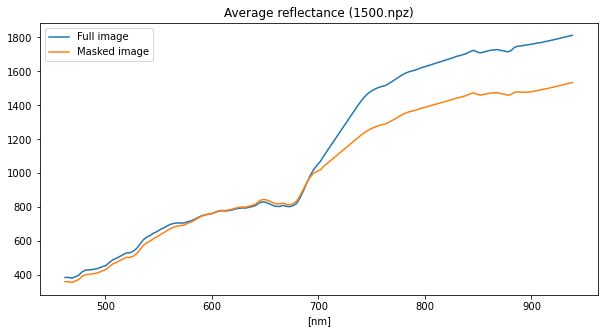

In [34]:
fig = plt.figure(figsize=(10, 5))

masked_scene_mean_spectral_reflectance = [arr[i,:,:].mean() for i in range(arr.shape[0])]
full_scene_mean_spectral_reflectance = [arr[i,:,:].data.mean() for i in range(arr.shape[0])]

plt.plot(wavelength_df['wavelength'], full_scene_mean_spectral_reflectance, label='Full image')
plt.plot(wavelength_df['wavelength'], masked_scene_mean_spectral_reflectance, label='Masked image')

plt.xlabel('[nm]')
plt.legend()
plt.title(f'Average reflectance ({hsi_path.split("/")[-1]})')
plt.show()

# Shapes and DS size

In [35]:
import os
trainSize = len(os.listdir('../train_data/train_data/train_data'))
print('Amount training images:',trainSize)                           

Amount training images: 1733


In [36]:
hsi_path = '../train_data/train_data/train_data/1500.npz'

sizes = []
for file in os.listdir('../train_data/train_data/train_data'):
    if file == '.DS_Store':
        continue
    with np.load('../train_data/train_data/train_data/' + file) as npz:
        arr = np.ma.MaskedArray(**npz)
        sizes.append(arr.shape[1:3])
        
print(sizes)

[(11, 11), (11, 11), (11, 11), (11, 11), (42, 42), (42, 42), (42, 42), (42, 42), (42, 42), (42, 42), (42, 42), (68, 27), (43, 44), (42, 42), (11, 11), (42, 42), (42, 42), (42, 42), (43, 42), (42, 42), (42, 42), (43, 42), (43, 44), (42, 42), (42, 42), (11, 11), (43, 42), (42, 42), (43, 42), (42, 42), (43, 38), (43, 44), (42, 42), (42, 42), (42, 42), (42, 42), (11, 11), (43, 42), (42, 42), (42, 43), (42, 43), (43, 43), (42, 43), (42, 43), (43, 43), (42, 43), (43, 43), (11, 11), (42, 42), (42, 42), (42, 42), (43, 42), (42, 42), (42, 42), (43, 42), (42, 42), (42, 36), (42, 42), (11, 11), (42, 42), (43, 42), (42, 42), (42, 42), (42, 42), (42, 42), (42, 42), (42, 42), (42, 42), (42, 42), (11, 11), (42, 42), (42, 42), (42, 42), (47, 46), (43, 43), (42, 43), (42, 43), (42, 43), (42, 43), (42, 42), (11, 11), (42, 42), (39, 44), (27, 41), (43, 42), (42, 42), (42, 42), (43, 42), (42, 42), (42, 43), (42, 45), (11, 11), (30, 42), (45, 42), (49, 44), (40, 44), (201, 94), (115, 103), (167, 117), (89,

In [37]:
#!pip install spectral

# Dimensionality Reduction

https://www.spectralpython.net/algorithms.html#:~:text=To%20reduce%20dimensionality%20using%20principal%20components%2C%20we%20can,pixels%20by%20projecting%20them%20onto%20the%20remaining%20eigenvectors.


In [38]:
hsi_path = '../train_data/train_data/train_data/1500.npz'

In [39]:
#load HS image
from spectral import *
with np.load(hsi_path) as npz:
    arr = np.ma.MaskedArray(**npz)

In [40]:
print(arr.shape)
#swap axis's for spectral library
arr2 = np.swapaxes(arr, 0, 2)
print(arr2.shape)

(150, 134, 76)
(76, 134, 150)



Many of the bands within hyperspectral images are often strongly correlated.
The principal components transformation represents a linear transformation of the original image bands to a
set of new, uncorrelated features. 
These new features correspond to the eigenvectors of the image covariance matrix, 
where the associated eigenvalue represents the variance in the direction of the eigenvector. 
A very large percentage of the image variance can be captured in a relatively small number of principal components 
(compared to the original number of bands) .

The SPy function principal_components computes the principal components of the image data 
and returns the mean, covariance, eigenvalues, and eigenvectors in a PrincipalComponents. 
This object also contains a transform to rotate data in to the space of the principal compenents, 
as well as a method to reduce the number of eigenvectors.


In [41]:
pc = principal_components(arr2)

(150, 150)


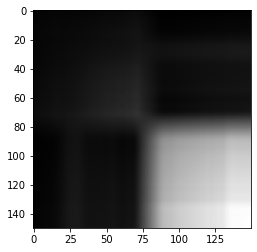

In [42]:
v = imshow(pc.cov)
print(pc.cov.shape)

In the covariance matrix display, whiter values indicate strong positive covariance, darker values indicate strong negative covariance, and grey values indicate covariance near zero.

To reduce dimensionality using principal components, we can sort the eigenvalues in descending order and then retain enough eigenvalues (an corresponding eigenvectors) to capture a desired fraction of the total image variance. We then reduce the dimensionality of the image pixels by projecting them onto the remaining eigenvectors. We will choose to retain a minimum of 99.9% of the total image variance.

8


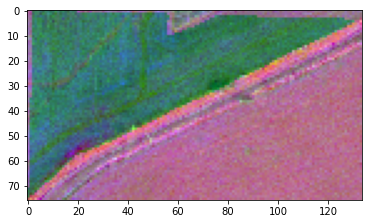

In [43]:
pc_0999 = pc.reduce(fraction=0.999)

# How many eigenvalues are left?

print(len(pc_0999.eigenvalues))


img_pc = pc_0999.transform(arr2)

v = imshow(img_pc[:,:,:150], stretch_all=True)

CoVariance over more samples

In [78]:
base_hsi_path = '../train_data/train_data/train_data/'
fType = '.npz'
samples = [0,320,640,960,1280,1600]

In [181]:
#divergent colourmap
cmaps = {}

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))


def plot_color_gradients(category, cmap_list):
    # Create figure and adjust figure height to number of colormaps
    nrows = len(cmap_list)
    figh = 0.35 + 0.15 + (nrows + (nrows - 1) * 0.1) * 0.22
    fig, axs = plt.subplots(nrows=nrows + 1, figsize=(6.4, figh))
    fig.subplots_adjust(top=1 - 0.35 / figh, bottom=0.15 / figh,
                        left=0.2, right=0.99)
    axs[0].set_title(f'{category} Colormap', fontsize=14)

    for ax, name in zip(axs, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap(name))
        ax.text(-0.01, 0.5, name, va='center', ha='right', fontsize=10,
                transform=ax.transAxes)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axs:
        ax.set_axis_off()
    
    axs[1].set_axis_on()
    axs[1].set_xticks([-1, 0, 1])

    # Save colormap list for later.
    cmaps[category] = cmap_list

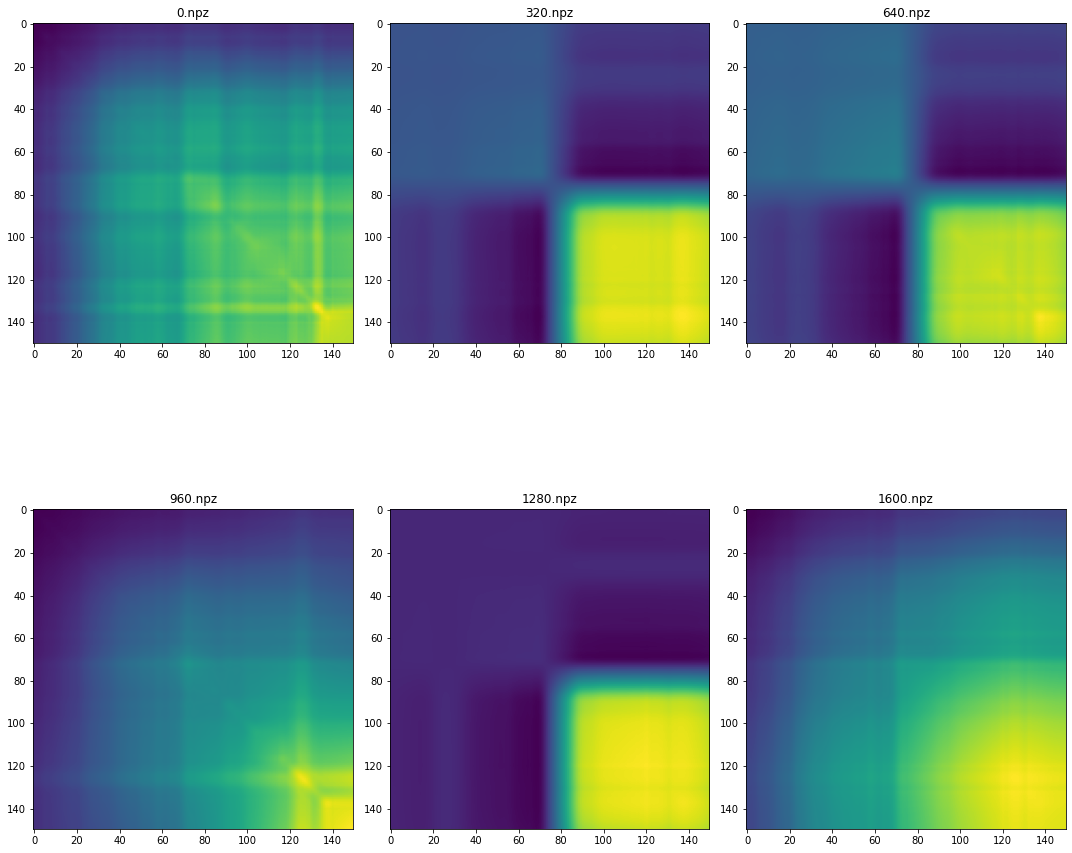

<Figure size 432x288 with 0 Axes>

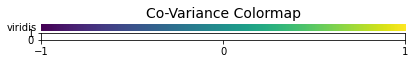

In [182]:
#dimensionality reduction over the range of samples
fig, axs = plt.subplots(2, 3, figsize=(15, 20))
plt.figure()

for i in range(0,len(samples)):
    p = base_hsi_path + str(samples[i]) + fType
    with np.load(p) as npz:
        samp_arr = np.ma.MaskedArray(**npz)
    
    samp_arr2 = np.swapaxes(samp_arr, 0, 2)
    pc = principal_components(samp_arr2)
    
    if i<3:
        axs[0,i].set_title(str(samples[i])+fType)
        axs[0,i].imshow(pc.cov)
    else:
        axs[1,i-3].set_title(str(samples[i])+fType)
        axs[1,i-3].imshow(pc.cov)
        
    fig.tight_layout()
    
plot_color_gradients('Co-Variance',['viridis'])

EigenValues for 0.npz: 31
EigenValues for 320.npz: 4
EigenValues for 640.npz: 22
EigenValues for 960.npz: 34
EigenValues for 1280.npz: 9
EigenValues for 1600.npz: 7


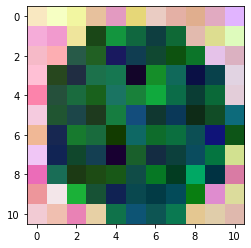

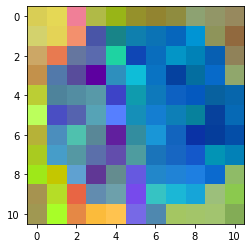

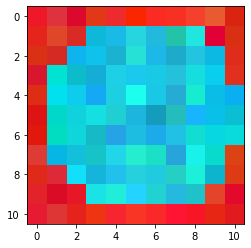

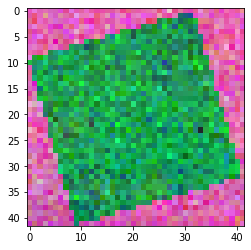

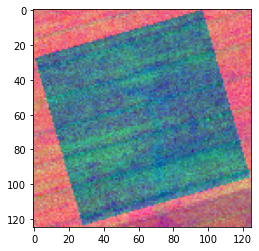

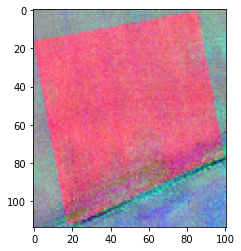

In [163]:
#This code may be taking the 'empty space' into account in masked images
#...also I don't really understand it yet

# How many eigenvalues are left?
for i in range(0,len(samples)):
    p = base_hsi_path + str(samples[i]) + fType
    with np.load(p) as npz:
        samp_arr = np.ma.MaskedArray(**npz)
    
    samp_arr2 = np.swapaxes(samp_arr, 0, 2)
    pc = principal_components(samp_arr2)
    
    pc_0999 = pc.reduce(fraction=0.999)
    print("EigenValues for", str(samples[i]) + fType + ':',len(pc_0999.eigenvalues))
    
    img_pc = pc_0999.transform(samp_arr2)
    
    
    imshow(img_pc[:,:,:150], stretch_all=True)

    fig.tight_layout()